In [12]:
import os
import cv2
from tqdm import tqdm
from util import read_images
from preprocessing import preprocess_image
%load_ext autoreload
%autoreload 2

folders =[]
# iterate over all folder in raw
raw_path = "data/raw"
for data_type_folder in os.listdir(raw_path):
    for skin_cancer_type_folder in os.listdir(os.path.join(raw_path, data_type_folder)):
          folders.append(os.path.join( data_type_folder, skin_cancer_type_folder))

for folder in folders:
  raw_path_folder = os.path.join(raw_path, folder)
  preprocessed_path_folder = os.path.join("data/preprocessed", folder)
  
  images = read_images(raw_path_folder)
  for i, (image_array, label) in enumerate(tqdm(images)):
      preprocessed_image = preprocess_image(image_array)
      

      # Save the image
      image_path = os.path.join(preprocessed_path_folder, f"{label}")
      cv2.imwrite(image_path, preprocessed_image)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


100%|██████████| 1197/1197 [00:07<00:00, 161.18it/s]


In [36]:
# feature extraction
import cv2
import pandas as pd
from tqdm import tqdm

from featureextraction import calculate_hog_with_pca, get_file_path_with_label, calculate_texture_features, calculate_rgb_statistic, calculate_hsv_statistic, calculate_lab_statistic, calculate_shape_features
%load_ext autoreload
%autoreload 2

preprocessed_path = "data/preprocessed/"
train_features, test_features = get_file_path_with_label(preprocessed_path)

def extract_glcm_color_features(image_path: str) -> pd.Series:
    image = cv2.imread(image_path)
    
    features = []
    features.append(calculate_texture_features(image))
    features.append(calculate_shape_features(image))
    features.append(calculate_rgb_statistic(image))
    features.append(calculate_hsv_statistic(image))
    features.append(calculate_lab_statistic(image))
    
    combined_features = pd.concat(features, axis=0)
    return pd.Series(combined_features)

tqdm.pandas(desc="Extracting GLCM and Color Features On Test Set")
preprocessed_test = test_features["image_path"].progress_apply(
    lambda x: extract_glcm_color_features(x)
)

test_features = pd.concat(
    [
        test_features,
        preprocessed_test,
        calculate_hog_with_pca(test_features["image_path"])
    ],
    axis=1,
)

tqdm.pandas(desc="Extracting GLCM and Color Features On Train Set")
preprocessed_train = train_features["image_path"].progress_apply(
    lambda x: extract_glcm_color_features(x)
)

train_features = pd.concat(
    [
        train_features,
        preprocessed_train,
        calculate_hog_with_pca(train_features["image_path"])
    ],
    axis=1,
)

# save the features
train_features.to_csv("data/features/train_features.csv", index=False)
test_features.to_csv("data/features/test_features.csv", index=False)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Extracting GLCM and Color Features On Train Set:  84%|████████▍ | 2218/2637 [02:24<00:26, 15.55it/s]c:\Users\drith\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\drith\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3747: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\drith\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:1193: RuntimeWarning: Mean of empty slice.
  mean = a.mean(axis, keepdims=True)
c:\Users\drith\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:1303: RuntimeWarning: Mean of empty slice.
  mean = a.mean(axis, keepdims=True)
c:\Users\drith\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\drith\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3747: RuntimeW

In [75]:
%load_ext autoreload
%autoreload 2
from lightgbm import LGBMClassifier
import pandas as pd
from matplotlib import pyplot as plt
import lightgbm as lgb

train_df = pd.read_csv("data/features/train_features.csv")
test_df = pd.read_csv("data/features/test_features.csv")

# display(train_df.head())

# drop the image path
train_df.drop(columns=["image_path"], inplace=True)
test_df.drop(columns=["image_path"], inplace=True)

# # drop hog features (starts with HOG_PCA)
# hog_columns = [col for col in train_df.columns if col.startswith("hog")]
# train_df.drop(columns=hog_columns, inplace=True)
# test_df.drop(columns=hog_columns, inplace=True)

# glcm_columns = [col for col in train_df.columns if col.startswith("glcm")]
# train_df.drop(columns=glcm_columns, inplace=True)
# test_df.drop(columns=glcm_columns, inplace=True)

# # drop color features
# rgb_columns = [col for col in train_df.columns if col.startswith("rgb")]
# train_df.drop(columns=rgb_columns, inplace=True)
# test_df.drop(columns=rgb_columns, inplace=True)

# hsv_columns = [col for col in train_df.columns if col.startswith("hsv")]
# train_df.drop(columns=hsv_columns, inplace=True)
# test_df.drop(columns=hsv_columns, inplace=True)

# lab_columns = [col for col in train_df.columns if col.startswith("lab_")]
# print(lab_columns)
# train_df.drop(columns=lab_columns, inplace=True)
# test_df.drop(columns=lab_columns, inplace=True)


# # # drop shape features
# shape_columns = [col for col in train_df.columns if col.startswith("shape")]
# train_df.drop(columns=shape_columns, inplace=True)  
# test_df.drop(columns=shape_columns, inplace=True)

# find columns with missing values
missing_columns = train_df.columns[train_df.isnull().any()].tolist()
print(missing_columns)

# print columsn
print(train_df.columns)

# do simple imputation
train_df.fillna(train_df.mean(), inplace=True)
test_df.fillna(test_df.mean(), inplace=True)

X_train = train_df.drop(columns=["label"])
y_train = train_df["label"]

X_test = test_df.drop(columns=["label"])
y_test = test_df["label"]

display(train_df)
display(test_df)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
['rgb_mean_b', 'rgb_mean_g', 'rgb_mean_r', 'rgb_var_b', 'rgb_var_g', 'rgb_var_r', 'rgb_skew_b', 'rgb_skew_g', 'rgb_skew_r', 'rgb_kurt_b', 'rgb_kurt_g', 'rgb_kurt_r', 'hsv_mean_h', 'hsv_mean_s', 'hsv_mean_v', 'hsv_var_h', 'hsv_var_s', 'hsv_var_v', 'hsv_skew_h', 'hsv_skew_s', 'hsv_skew_v', 'hsv_kurt_h', 'hsv_kurt_s', 'hsv_kurt_v']
Index(['label', 'glcm_contrast', 'glcm_energy', 'glcm_homogeneity',
       'glcm_correlation', 'shape_area', 'shape_mean', 'shape_std_dev',
       'shape_variance', 'rgb_mean_b',
       ...
       'hog_pca_90', 'hog_pca_91', 'hog_pca_92', 'hog_pca_93', 'hog_pca_94',
       'hog_pca_95', 'hog_pca_96', 'hog_pca_97', 'hog_pca_98', 'hog_pca_99'],
      dtype='object', length=154)


,label,glcm_contrast,glcm_energy,glcm_homogeneity,glcm_correlation,shape_area,shape_mean,shape_std_dev,shape_variance,rgb_mean_b,...,hog_pca_90,hog_pca_91,hog_pca_92,hog_pca_93,hog_pca_94,hog_pca_95,hog_pca_96,hog_pca_97,hog_pca_98,hog_pca_99
0,0,93.391624,0.842006,0.892832,0.926340,7338.0,8.676738,25.046925,627.348427,59.604965,...,0.320255,0.115166,0.179731,0.049218,-0.058604,0.289362,-0.072908,0.040179,-0.094323,0.268343
1,0,69.751341,0.860963,0.906870,0.932283,6379.0,7.120655,22.571701,509.481695,48.894395,...,0.161158,-0.234555,0.095661,0.076138,-0.357983,-0.271117,-0.176835,-0.467264,-0.182742,0.020098
2,0,138.679523,0.617348,0.777455,0.960162,18111.0,27.429189,41.580243,1728.916582,59.725814,...,-0.254912,0.338506,-0.102672,-0.018092,0.412774,-0.040443,0.140801,0.259564,0.023177,-0.292686
3,0,426.255921,0.518059,0.732344,0.953783,23014.0,52.411113,68.042399,4629.768127,128.759455,...,0.344021,-0.807711,-0.096633,-0.725788,-0.307027,0.084581,0.123040,0.196591,0.067232,-0.065297
4,0,266.783045,0.549488,0.738708,0.969553,21734.0,51.865713,66.103077,4369.616772,103.821776,...,-0.567883,0.239962,0.050836,0.330878,0.040661,0.126740,-0.260537,0.491815,-0.063053,0.210792
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2632,1,508.377759,0.290644,0.578055,0.944126,34415.0,82.320352,67.378611,4539.877285,122.682687,...,-0.003338,0.347974,0.335287,-0.584966,-0.075991,0.397998,-0.593528,0.421850,0.632411,0.371460
2633,1,141.433506,0.824064,0.882524,0.920347,8118.0,10.101662,29.794981,887.740881,68.161738,...,-0.187884,-0.117264,-0.003951,0.184237,-0.401409,0.695454,-0.160546,0.324904,-0.909842,0.314669
2634,1,207.060640,0.499004,0.688387,0.946743,23883.0,34.081154,43.986866,1934.844418,64.310922,...,0.163690,0.228819,-0.006751,0.273112,0.135500,0.453129,-0.525613,0.361016,-0.275944,0.834291
2635,1,208.010658,0.780332,0.857123,0.959335,10230.0,21.923190,50.328831,2532.991230,75.528473,...,-0.367289,0.271518,-0.187724,-0.017919,0.510575,-0.425035,0.091980,-0.076671,0.455918,0.558465


,label,glcm_contrast,glcm_energy,glcm_homogeneity,glcm_correlation,shape_area,shape_mean,shape_std_dev,shape_variance,rgb_mean_b,...,hog_pca_90,hog_pca_91,hog_pca_92,hog_pca_93,hog_pca_94,hog_pca_95,hog_pca_96,hog_pca_97,hog_pca_98,hog_pca_99
0,0,91.794641,0.934269,0.954663,0.911947,2863.0,4.259208,22.699220,515.254599,78.406067,...,0.073530,0.004916,0.159028,-0.138720,-0.227388,-0.017207,0.010378,0.314807,0.036662,0.195404
1,0,324.379338,0.674789,0.788984,0.953016,15256.0,32.821907,58.548292,3427.902554,98.306288,...,0.496263,0.118572,0.384291,-0.103620,0.064686,0.128177,0.728204,-0.272074,0.358052,-0.093004
2,0,176.517885,0.539483,0.715509,0.956987,22125.0,35.049346,45.251948,2047.738836,58.115078,...,0.224629,-0.139660,-0.705251,0.206175,0.201785,-0.144295,0.078552,0.322402,-0.161583,0.320674
3,0,231.369201,0.589564,0.823116,0.982337,20022.0,60.766203,80.911381,6546.651513,151.923098,...,-0.774852,-0.026624,-0.284044,0.129028,-0.104559,0.535004,-0.121553,0.011118,-0.335087,-0.374432
4,0,254.775510,0.684646,0.822070,0.965889,14910.0,35.001256,60.913204,3710.418426,107.887132,...,0.018831,-0.422932,0.198284,-0.083530,-0.520661,0.104933,-0.105079,-0.266780,-0.269638,-0.098780
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
655,1,148.557824,0.645167,0.761055,0.949050,16826.0,23.432418,38.041341,1447.143631,71.000345,...,0.040954,0.242251,0.285990,0.245982,0.478251,0.022675,0.194170,-0.009624,-0.010290,0.317816
656,1,179.138197,0.723891,0.821565,0.947377,12720.0,20.054668,41.069036,1686.665757,79.260968,...,0.571590,0.309788,0.120777,0.465259,0.166374,0.030204,0.332480,-0.120804,-0.553310,-0.451009
657,1,417.185047,0.208068,0.448520,0.918219,38525.0,67.554289,50.680844,2568.547993,86.387029,...,-0.435065,0.052188,0.248687,-0.211699,-0.500775,0.277620,0.429534,0.237385,0.042160,0.551657
658,1,163.825899,0.606408,0.738609,0.933818,18649.0,22.446628,35.058574,1229.103617,53.405120,...,0.362785,0.724532,0.221091,-0.218791,0.039231,-0.066956,0.206432,-0.546626,0.518134,-0.400453


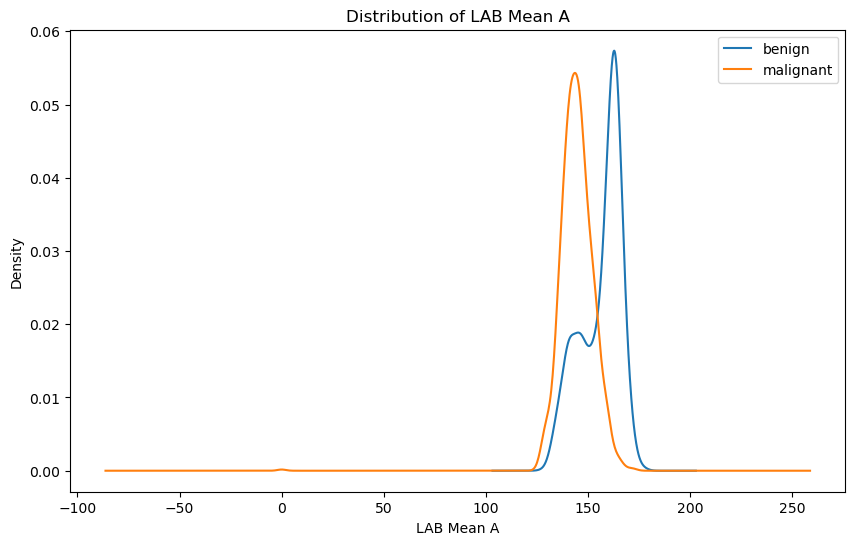

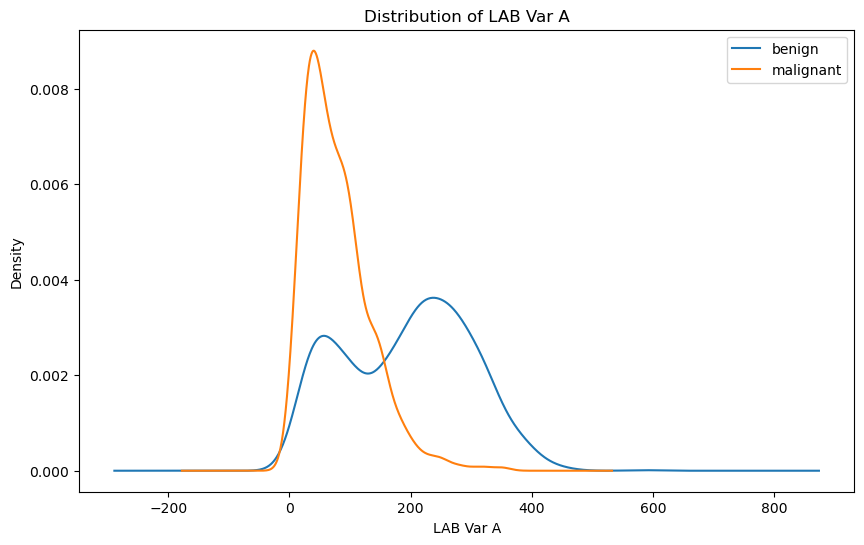

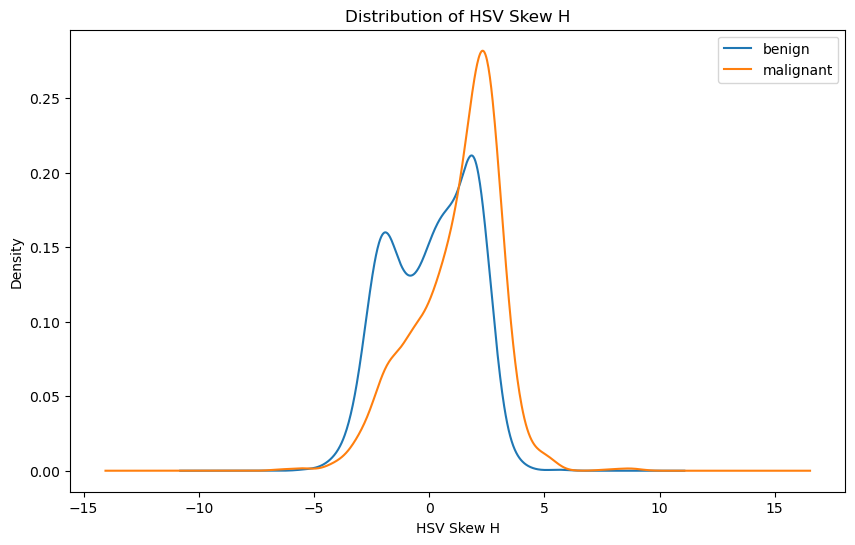

In [103]:
# visualize the label distribution on lab_mean_a between benign and malignant 
plt.figure(figsize=(10, 6))
plt.title("Distribution of LAB Mean A")
plt.xlabel("LAB Mean A")
plt.ylabel("Density")
train_df[train_df["label"] == 0]["lab_mean_a"].plot(kind="kde", label="benign")
train_df[train_df["label"] == 1]["lab_mean_a"].plot(kind="kde", label="malignant")
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.title("Distribution of LAB Var A")
plt.xlabel("LAB Var A")
plt.ylabel("Density")
train_df[train_df["label"] == 0]["lab_var_a"].plot(kind="kde", label="benign")
train_df[train_df["label"] == 1]["lab_var_a"].plot(kind="kde", label="malignant")
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.title("Distribution of HSV Skew H")
plt.xlabel("HSV Skew H")
plt.ylabel("Density")
train_df[train_df["label"] == 0]["hsv_skew_h"].plot(kind="kde", label="benign")
train_df[train_df["label"] == 1]["hsv_skew_h"].plot(kind="kde", label="malignant")
plt.legend()
plt.show()



LightGBM
              precision    recall  f1-score   support

           0       0.91      0.70      0.79       360
           1       0.72      0.92      0.81       300

    accuracy                           0.80       660
   macro avg       0.82      0.81      0.80       660
weighted avg       0.82      0.80      0.80       660



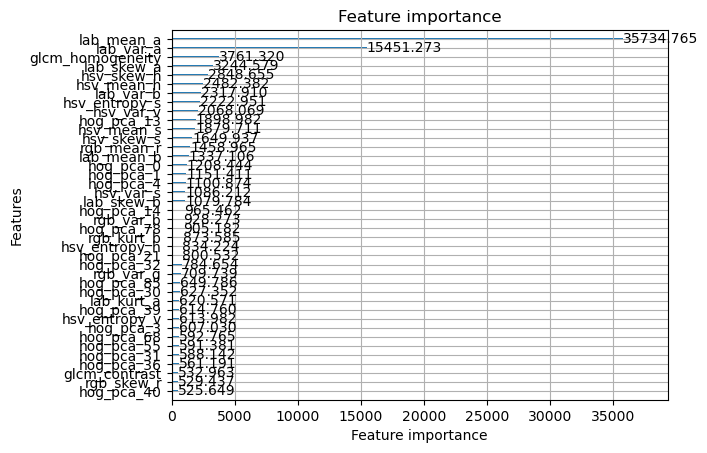

20


In [73]:
# fit lightgbm

from sklearn.svm import SVC
from xgboost import XGBClassifier
import numpy as np
# Best Hyperparameters: {'subsample': 0.7, 'reg_lambda': 0.01, 'reg_alpha': 0.001, 'num_leaves': 64, 'n_estimators': 500, 'min_split_gain': 0.025, 'min_child_weight': 20, 'max_depth': 10, 'learning_rate': 0.01, 'colsample_bytree': 0.6}
lgbm = LGBMClassifier(  
    subsample=0.7,
    reg_lambda=0.01,
    reg_alpha=0.001,
    num_leaves=64,
    n_estimators=500,
    min_split_gain=0.025,
    min_child_weight=20,
    max_depth=10,
    learning_rate=0.01,
    colsample_bytree=0.6,
    silent=-1,
    verbose=-1,
)

# svm = SVC(kernel="linear", C=10, gamma=0.1, random_state=42, probability=True)

# svm.fit(
#     X_train,
#     y_train,
# )


lgbm.fit(
    X_train,
    y_train,
    eval_set=[(X_test, y_test)],
)

# classification report
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

print("LightGBM")
y_pred = lgbm.predict(X_test)
y_pred_proba = lgbm.predict_proba(X_test)

y_pred_proba = pd.DataFrame(y_pred_proba)
y_pred_proba.to_csv("data/lgbm_y_pred_proba.csv", index=False, float_format="%.5f")

print(classification_report(y_test, y_pred))



# confusion matrix
# cm = confusion_matrix(test_df["label"], y_pred)
# sns.heatmap(cm, annot=True, fmt="d")

# misclassified_indices = test_df.index[test_df["label"] != y_pred]
# # Display the misclassified instances
# misclassified_df = test_df.loc[misclassified_indices]
# print("Misclassified Instances:")
# display(misclassified_df)

# plot feature importance
lgb.plot_importance(lgbm, importance_type="gain", max_num_features=40)
plt.show()

feature_importance = lgbm.feature_importances_

# Step 3: Identify the least important feature
least_important_feature = np.argmin(feature_importance)
print(least_important_feature)

# delete the least important feature
# X_train = X_train.drop(columns=X_train.columns[least_important_feature], inplace=True)
# X_test = X_test.drop(columns=X_test.columns[least_important_feature], inplace=True)


In [3]:
from sklearn.model_selection import RandomizedSearchCV
from lightgbm import LGBMClassifier
import numpy as np

# Define the parameter grid for random search
param_grid = {
    'n_estimators': [500, 1000, 1500],
    'learning_rate': np.logspace(-4, 0, 4),
    'num_leaves': [16, 32, 64],
    'colsample_bytree': np.linspace(0.6, 1.0, 5),
    'subsample': np.linspace(0.6, 1.0, 5),
    'max_depth': [6, 8, 10],
    'reg_alpha': np.logspace(-3, 0, 4),
    'reg_lambda': np.logspace(-3, 0, 4),
    'min_split_gain': np.linspace(0.0, 0.1, 5),
    'min_child_weight': [20, 30, 40],
}

# Create the LightGBM classifier
lgbm = LGBMClassifier(silent=-1, verbose=-1)

# Create the RandomizedSearchCV object
random_search = RandomizedSearchCV(
    lgbm,
    param_distributions=param_grid,
    n_iter=10,  # Adjust the number of iterations as needed
    scoring='accuracy',  # Use an appropriate scoring metric
    cv=5,  # Number of cross-validation folds
    verbose=2,
    n_jobs=-1,  # Use all available CPU cores
    random_state=42,  # Set a random seed for reproducibility
)

# Example usage:
X_train = train_df.drop(columns=["label"])
y_train = train_df["label"]
# Assuming you have your training data X_train and corresponding labels y_train
random_search.fit(X_train, y_train)

# Print the best hyperparameters
print("Best Hyperparameters:", random_search.best_params_)
print("Best Score:", random_search.best_score_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Hyperparameters: {'subsample': 0.9, 'reg_lambda': 1.0, 'reg_alpha': 0.1, 'num_leaves': 32, 'n_estimators': 1000, 'min_split_gain': 0.025, 'min_child_weight': 20, 'max_depth': 10, 'learning_rate': 0.046415888336127774, 'colsample_bytree': 0.6}
Best Score: 0.79826706342361


In [12]:

import pandas as pd
import numpy as np

# save ypred to csv
df = pd.DataFrame(y_pred, columns=["label"])
df.to_csv("data/lgbm_ypred.csv", index=False)

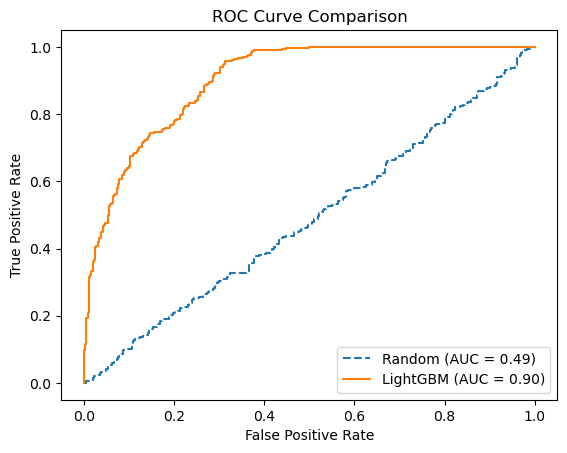

In [ ]:
# Import necessary libraries
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

# Assuming test_df["label"] contains the true labels for your test data

# Generate random predictions (assuming a binary classification problem)
random_predictions = np.random.rand(len(test_df))

# Compute ROC curve and AUC for the random classifier
fpr_random, tpr_random, thresholds_random = roc_curve(test_df["label"], random_predictions)
auc_random = roc_auc_score(test_df["label"], random_predictions)

# Compute ROC curve and AUC for the LightGBM model
y_pred_proba = lgbm.predict_proba(test_df.drop(columns=["label"]))
fpr_lgbm, tpr_lgbm, thresholds_lgbm = roc_curve(test_df["label"], y_pred_proba[:, 1])
auc_lgbm = roc_auc_score(test_df["label"], y_pred_proba[:, 1])

# Plot ROC curves
plt.plot(fpr_random, tpr_random, linestyle='--', label=f'Random (AUC = {auc_random:.2f})')
plt.plot(fpr_lgbm, tpr_lgbm, label=f'LightGBM (AUC = {auc_lgbm:.2f})')

# Customize plot
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()


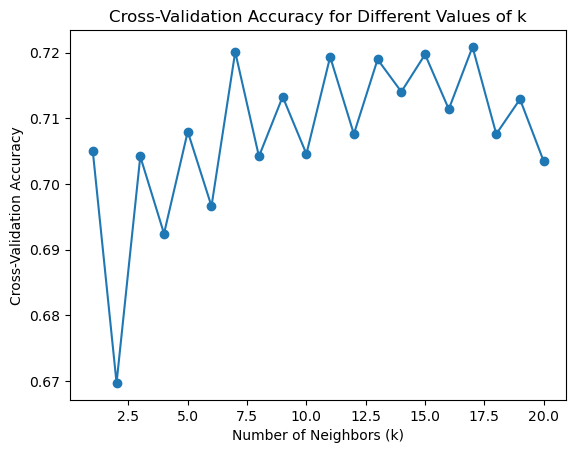

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
import pandas as pd

# Assume you have your features X and labels y
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a KNN classifier
knn = KNeighborsClassifier()

# Define a range of k values to test
k_values = np.arange(1, 21)

# Perform cross-validation for each k value
cross_val_scores = []

for k in k_values:
    knn.n_neighbors = k
    scores = cross_val_score(knn, train_df.drop(columns=["label"]), train_df["label"], cv=5, scoring="accuracy")
    cross_val_scores.append(np.mean(scores))

# Plot the cross-validation scores for each k
plt.plot(k_values, cross_val_scores, marker='o')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Cross-Validation Accuracy')
plt.title('Cross-Validation Accuracy for Different Values of k')
plt.show()


In [2]:
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import KFold, train_test_split
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score


# Vary the training set size from 10% to 100%
training_sizes = np.arange(0.6, 1.1, 0.1)

# Initialize lists to store performance metrics
svm_accuracies = []
lgbm_accuracies = []
datasets = pd.concat([train_df, test_df], axis=0)
X_data = datasets.drop(columns=["label"])
y_data = datasets["label"]
# Loop through different training set sizes
for size in training_sizes:
    print(f"Training Size: {size:.2f}")
    size = min(size, 0.9999)
    

    num_samples = int(size * len(datasets))


    # Define the number of folds
    num_folds = 5

    # Create a KFold object
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)
    X_train_subset, _, y_train_subset, _ = train_test_split(X_data, y_data, train_size=num_samples, random_state=42)

    # SVM Training
    svm_model = SVC(kernel="linear", C=10, gamma=0.1, random_state=42)
    svm_result = cross_val_score(svm_model, X_train_subset, y_train_subset, cv=kf, scoring='accuracy', n_jobs=-1, verbose=10)
    
    # LightGBM Training
    lgbm_model = LGBMClassifier(  
        subsample=0.7,
        reg_lambda=0.01,
        reg_alpha=0.001,
        num_leaves=64,
        n_estimators=500,
        min_split_gain=0.0105,
        min_child_weight=20,
        max_depth=10,
        learning_rate=0.01,
        colsample_bytree=0.6,
        silent=-1,
        verbose=-1,
    )
    lgmb_result = cross_val_score(lgbm_model, X_train_subset, y_train_subset, cv=kf, scoring='accuracy', n_jobs=-1, verbose=10)
    
    
    # Append the accuracies to the lists
    svm_accuracies.append(svm_result)
    lgbm_accuracies.append(lgmb_result)
    # save to csv
    df = pd.DataFrame(svm_accuracies, columns=["fold1", "fold2", "fold3", "fold4", "fold5"])
    df.to_csv(f"data/svm_accuracies_{size:.2f}.csv", index=False, float_format="%.5f")

    df = pd.DataFrame(lgbm_accuracies, columns=["fold1", "fold2", "fold3", "fold4", "fold5"])
    df.to_csv(f"data/lgbm_accuracies_{size:.2f}.csv", index=False, float_format="%.5f")
    
    
    
    



Training Size: 0.60


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  8.4min remaining: 12.6min
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:  8.7min remaining:  5.8min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 69.1min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 69.1min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    6.0s remaining:    9.0s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    6.2s remaining:    4.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Training Size: 0.70


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  9.6min remaining: 14.3min
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed: 11.7min remaining:  7.8min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 36.0min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 36.0min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    8.1s remaining:   12.2s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    8.1s remaining:    5.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.2s finished


Training Size: 0.80


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed: 13.2min remaining: 19.8min
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed: 13.7min remaining:  9.2min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 16.3min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 16.3min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    4.7s remaining:    7.2s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    4.8s remaining:    3.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Training Size: 0.90


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed: 12.5min remaining: 18.8min
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed: 12.8min remaining:  8.6min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 29.7min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 29.7min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    8.3s remaining:   12.5s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    8.4s remaining:    5.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.4s finished


Training Size: 1.00


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed: 14.0min remaining: 21.0min
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed: 16.7min remaining: 11.1min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 27.4min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 27.4min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    4.1s remaining:    6.2s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    7.3s remaining:    4.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Training Size: 1.10


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed: 12.8min remaining: 19.2min
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed: 15.3min remaining: 10.2min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 25.7min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 25.7min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    4.7s remaining:    7.1s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    7.1s remaining:    4.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.2s finished


In [5]:
import numpy as np
from dask.distributed import Client

import joblib
from sklearn.model_selection import KFold
from sklearn.svm import SVC
from dask_ml.model_selection import train_test_split

client = Client(processes=False)             # create local cluster

datasets = pd.concat([train_df, test_df], axis=0)

param_space = {
    'C': np.logspace(-6, 6, 13),
    'gamma': np.logspace(-8, 8, 17),
    'tol': np.logspace(-4, -1, 4),
    'class_weight': [None, 'balanced'],
}

model = SVC(kernel='rbf')
svm_model = SVC(kernel="linear", C=10, gamma=0.1, random_state=42)
num_folds = 5  # You can choose the number of folds (e.g., 5 or 10)

# Create a KFold object
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)


with joblib.parallel_backend('dask'):
    cross_val_results = cross_val_score(knn, X_train, y_train, cv=kf, scoring='accuracy')


In [2]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.svm import SVC
import numpy as np

# Assuming train_df and test_df are Dask DataFrames
datasets = pd.concat([train_df, test_df], axis=0)


X_data = datasets.drop(columns=["label"])
y_data = datasets["label"]

# Define the number of folds
num_folds = 5

# Create a KFold object
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Create an SVM model
svm = SVC(kernel="linear", C=10, gamma=0.1, random_state=42)



# Use cross_val_score with Pandas DataFrame

# Print the result
print(result)
print(f"Mean Accuracy: {np.mean(result)}")


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


[0.82272727 0.80909091 0.79362671 0.79666161 0.74962064]
Mean Accuracy: 0.7943454269554422


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 25.3min finished
